## _Multi-layer Perceptron regressor_ dados completos

Nesse notebook aplicamos a tecnica de _Multi-layer Perceptron regressor_.

O que é feito aqui pode ser dividido nos seguintes topicos:

- Abertura do dataset de doenças desagrupadas
- Seleção das doenças com maior incidencia
- Realização de um MLP regressor que tem como `y` a prevalencia
- Analise do RMSE das melhores regressões

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

### A rede

Aqui definimos a função que implementa a rede neural regressora e retorna as métricas que serão usadas para avaliar para quais doencas o modelo teve um bom desempenho.

In [2]:
def regressao(X, y):

    # colocando y em [0,1]
    y /= y.max()
    
    # separando conjunto de teste e treinamento
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    # regressão Linear 
    reg = MLPRegressor(hidden_layer_sizes=(100, 60, 20),
                       solver='adam',
                       random_state=42).fit(X_train, y_train)
    y_pred = reg.predict(X_test)
        
    # RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse, y_test, y_pred

## Desagrupados

In [3]:
desagrupados = pd.read_csv('../../../dados/formatado_desagrupado.csv', sep = ';')
desagrupados.sample(5)

cod_muni  qtd_mora  incidencia diag_princ  prevalencia  \
91289     313660      5505           1       K768     0.000182   
266715    431240     58402           4       K590     0.000069   
266694    431240     58402           2       K510     0.000034   
244210    430260      3672           1       K650     0.000272   
115140    315310      5514           4       K565     0.000725   

        renda_media_mora  SITU1_entorno  SITU2_entorno  SITU3_entorno  \
91289           0.168624       0.261948       0.000000       0.256503   
266715          0.435836       0.860450       0.051633       0.000000   
266694          0.435836       0.860450       0.051633       0.000000   
244210          0.225578       0.616846       0.000000       0.000000   
115140          0.127569       0.336040       0.000000       0.000000   

        SITU4_entorno  ...  V032_domicilio02  V033_domicilio02  \
91289        0.016334  ...          0.010081          0.218182   
266715       0.000000  ...          0.042195          0.004292   
266694       0.000000  ...          0.042195          0.004292   
244210       0.000000  ...          0.171259          0.264992   
115140       0.000000  ...          0.062127          0.572332   

        V034_domicilio02  V035_domicilio02  V036_domicilio02  \
91289           0.002340          0.002340          0.000000   
266715          0.001212          0.000236          0.000000   
266694          0.001212          0.000236          0.000000   
244210          0.085900          0.005132          0.000000   
115140          0.011920          0.037024          0.005779   

        V037_domicilio02  V038_domicilio02  V041_domicilio02  \
91289           0.004860          0.980378          0.010621   
266715          0.001145          0.980998          0.001952   
266694          0.001145          0.980998          0.001952   
244210          0.004592          0.981091          0.010805   
115140          0.003612          0.985732          0.010114   

        V045_domicilio02  V089_domicilio02  
91289           0.503330          0.496670  
266715          0.492216          0.507784  
266694          0.492216          0.507784  
244210          0.504052          0.495948  
115140          0.502077          0.497923  

[5 rows x 83 columns]

### Seleção de doenças

Primeiro fazemos uma seleção das doenças que fazem sentido serem analisadas, para isso usamos a lógica que uma doença com menos do que X casos não tem sentido ser analisada. 

No contexto específico, definimos uma variável "cutoff_incidencia" que define qual é o X para qual as doenças com menos casos do que esse número serão ignoradas

In [4]:
# acho que 10000 é um numero muito alto ainda
cutoff_incidencia = 10000

doencas_incidencia = desagrupados.groupby(['diag_princ']).sum()[['incidencia']]
doencas_incidencia.head(5)

incidencia
diag_princ            
J00                141
J010               257
J011                63
J012                76
J013               221

In [5]:
doencas_selected = doencas_incidencia[doencas_incidencia['incidencia'] >= cutoff_incidencia]
doencas_selected.head(5)

incidencia
diag_princ            
J039             11920
J040             12116
J042             14575
J068             37124
J100             13278

### Análise e resultados

Nesse bloco chamamos a função da regressão para as doenças selecionadas, fazendo a comparação entre uso ou não do PCA.

In [6]:
lista_doencas = doencas_selected.reset_index()['diag_princ'].unique()
lista_rmse = []
lista_y_test = []
lista_y_pred = []

for doenca in lista_doencas:
    df = desagrupados[desagrupados['diag_princ'] == doenca].copy()

    # Separando 
    y = df[['prevalencia']].to_numpy()
    X = df[df.columns[5:]].to_numpy()

    print('\n------- CID: ' + doenca)
    print('Quantidade de entradas: ' + str(y.shape[0]))
    print('Executando MLP')

    rmse, y_test, y_pred = regressao(X, y)    

    lista_rmse.append(rmse)
    lista_y_test.append(y_test)
    lista_y_pred.append(y_pred)

    print('RMSE: ' + str(rmse))



------- CID: J039
Quantidade de entradas: 1183
Executando MLP
RMSE: 0.06621103556985265

------- CID: J040
Quantidade de entradas: 1263
Executando MLP
RMSE: 0.06526243282540257

------- CID: J042
Quantidade de entradas: 887
Executando MLP
RMSE: 0.0386576936661843

------- CID: J068
Quantidade de entradas: 1746
Executando MLP
RMSE: 0.021978102987496563

------- CID: J100
Quantidade de entradas: 760
Executando MLP
RMSE: 0.08389114708030422

------- CID: J110
Quantidade de entradas: 1298
Executando MLP
RMSE: 0.052128166838677534

------- CID: J128
Quantidade de entradas: 1395
Executando MLP
RMSE: 0.08885816382696107

------- CID: J129
Quantidade de entradas: 1236
Executando MLP
RMSE: 0.07888481015025489

------- CID: J158
Quantidade de entradas: 1907
Executando MLP
RMSE: 0.11137233417740437

------- CID: J159
Quantidade de entradas: 2127
Executando MLP
RMSE: 0.0787140545914211

------- CID: J168
Quantidade de entradas: 570
Executando MLP
RMSE: 0.09408905291310647

------- CID: J180
Quant

#### RMSE medio

Calculando o RMSE medio do modelo

In [7]:
erro_medio = np.mean(lista_rmse)
print("Erro medio: " + str(erro_medio))

Erro medio: 0.07162065488644413


## Melhores avaliações

Agora, vamos selecionar as 20 doenças com melhor erro $ R^2 $, ou seja, as doenças que nossa regressão linear melhor conseguiu estimar a prevalencia.

In [8]:
# ordenando as doencas pelo melhor (menor) erro
lista_rmse, lista_doencas, lista_y_test, lista_y_pred = zip(*sorted(zip(lista_rmse, lista_doencas, lista_y_test, lista_y_pred)))
# pegando so os 10 primeiros
lista_rmse, lista_doencas, lista_y_test, lista_y_pred = lista_rmse[:20], lista_doencas[:20], lista_y_test[:20], lista_y_pred[:20]

lista_rmse

(0.01903645984905355,
 0.020628020665272015,
 0.021978102987496563,
 0.0233978597044309,
 0.025398678334144453,
 0.028884062977848148,
 0.03099048166497709,
 0.03430176005163006,
 0.0386576936661843,
 0.039682838742353815,
 0.040577518157946295,
 0.04513565140591859,
 0.04531910761723752,
 0.046803125117050155,
 0.049373642276902205,
 0.04993597446491319,
 0.05025916538696637,
 0.05109081962840115,
 0.052128166838677534,
 0.05248319292627371)

No handles with labels found to put in legend.


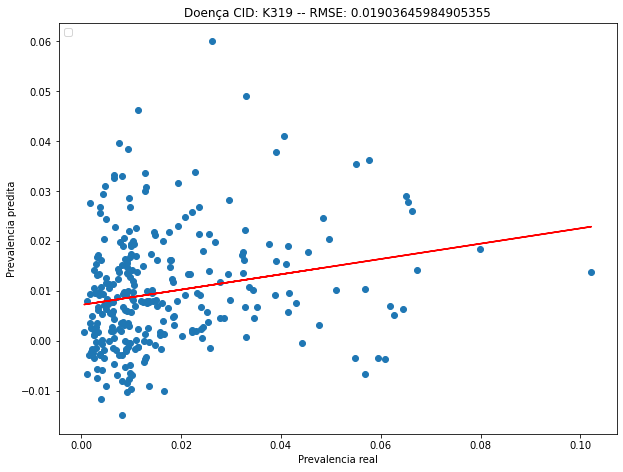

No handles with labels found to put in legend.


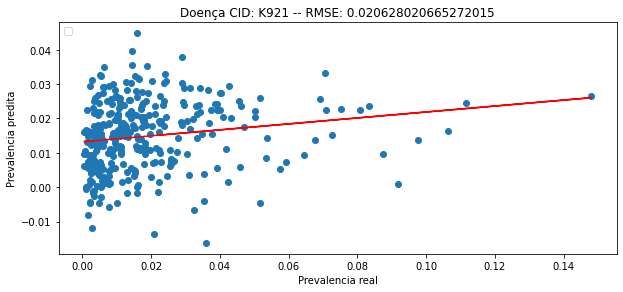

No handles with labels found to put in legend.


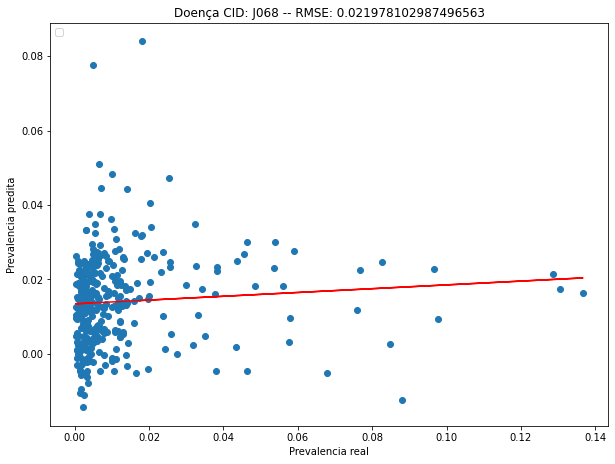

No handles with labels found to put in legend.


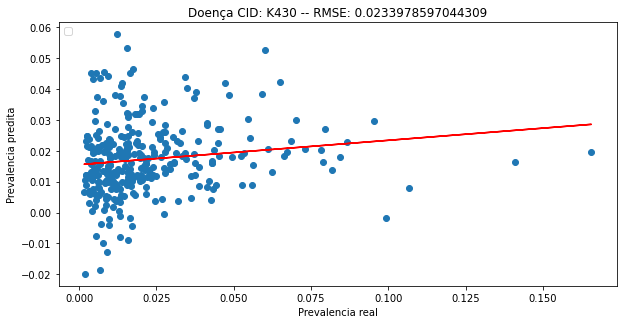

No handles with labels found to put in legend.


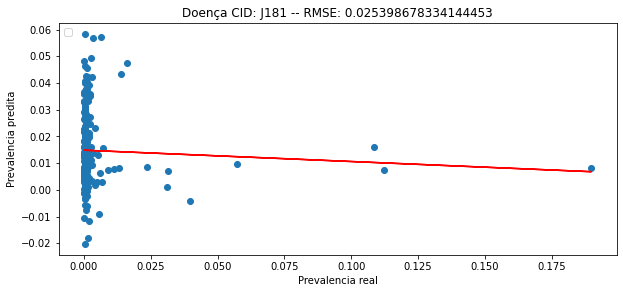

No handles with labels found to put in legend.


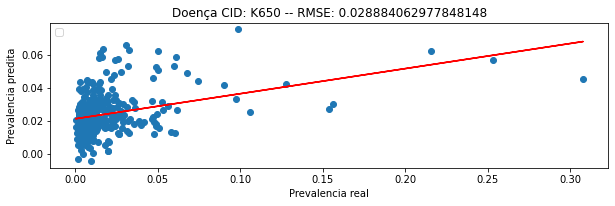

No handles with labels found to put in legend.


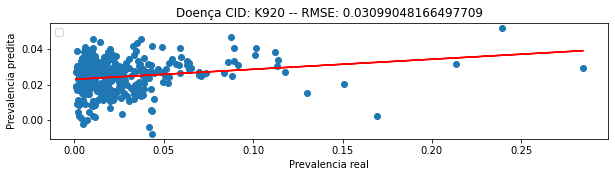

No handles with labels found to put in legend.


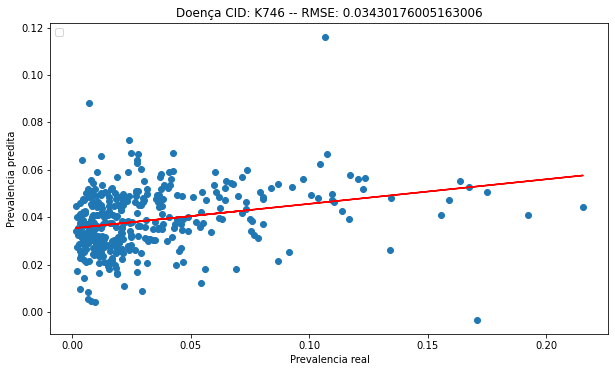

No handles with labels found to put in legend.


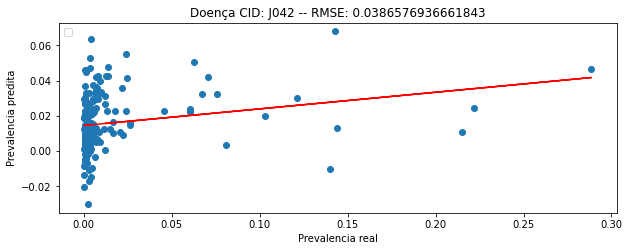

No handles with labels found to put in legend.


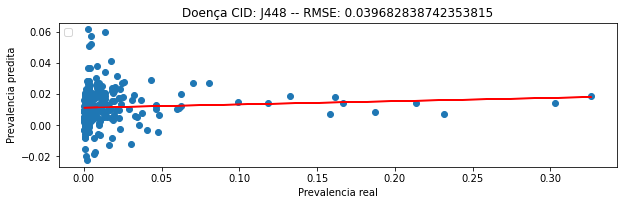

No handles with labels found to put in legend.


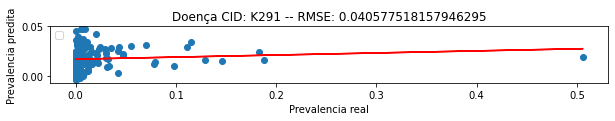

No handles with labels found to put in legend.


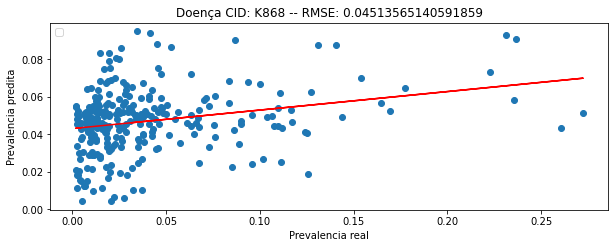

No handles with labels found to put in legend.


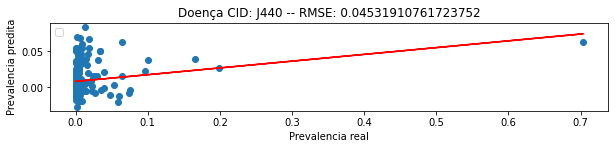

No handles with labels found to put in legend.


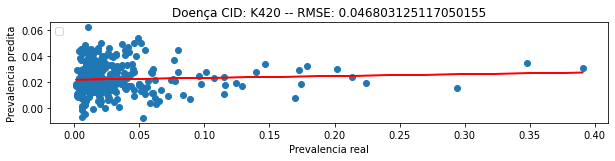

No handles with labels found to put in legend.


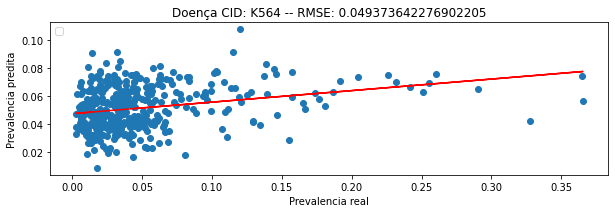

No handles with labels found to put in legend.


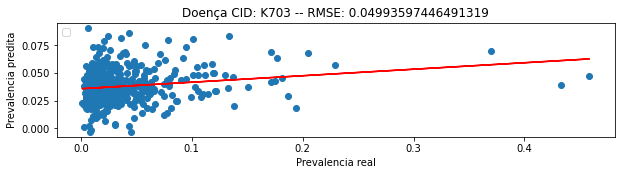

No handles with labels found to put in legend.


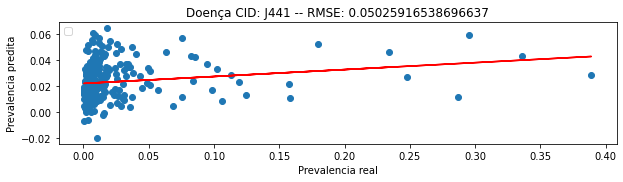

No handles with labels found to put in legend.


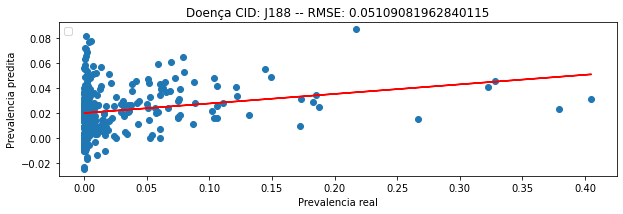

No handles with labels found to put in legend.


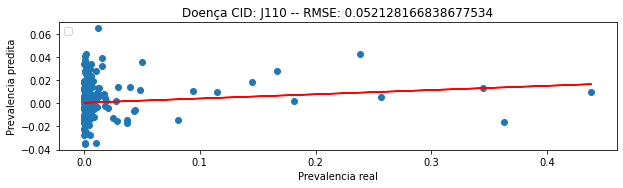

No handles with labels found to put in legend.


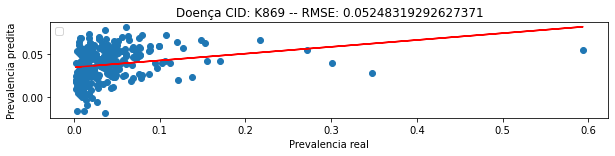

In [9]:
for doenca, erro, y_test, y_pred in zip(lista_doencas, lista_rmse, lista_y_test, lista_y_pred):

    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)

    ax1.scatter(y_test, y_pred)
    m, b = np.polyfit(np.squeeze(y_test), np.squeeze(y_pred), 1)
    ax1.plot(y_test, m*y_test + b, color='red')

    plt.gca().set_aspect('equal', adjustable='box') # deixa o aspecto dos eixos iguais
    plt.legend(loc='upper left')

    plt.xlabel('Prevalencia real')
    plt.ylabel('Prevalencia predita')
    plt.title('Doença CID: ' + doenca + ' -- RMSE: ' + str(erro))
    plt.show()